In [2]:
!conda install -y scipy

In [ ]:
%matplotlib inline

import os, re

import boto3
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# some helpful utility functions are defined in the Python module
# "generate_example_data" located in the same directory as this
# notebook
from generate_example_data import generate_griffiths_data, plot_lda, match_estimated_topics

# accessing the SageMaker Python SDK
import sagemaker
from sagemaker.amazon.common import numpy_to_record_serializer
from sagemaker.predictor import csv_serializer, json_deserializer

In [ ]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/DEMO-lda-introduction'

print('Training input/output will be stored in {}/{}'.format(bucket, prefix))
print('\nIAM Role: {}'.format(role))

In [4]:
print('Generating example data...')
num_documents = 6000
num_topics = 5
known_alpha, known_beta, documents, topic_mixtures = generate_griffiths_data(
    num_documents=num_documents, num_topics=num_topics)
vocabulary_size = len(documents[0])

# separate the generated data into training and tests subsets
num_documents_training = int(0.9*num_documents)
num_documents_test = num_documents - num_documents_training

documents_training = documents[:num_documents_training]
documents_test = documents[num_documents_training:]

topic_mixtures_training = topic_mixtures[:num_documents_training]
topic_mixtures_test = topic_mixtures[num_documents_training:]

print('documents_training.shape = {}'.format(documents_training.shape))
print('documents_test.shape = {}'.format(documents_test.shape))

Generating example data...
documents_training.shape = (5400, 25)
documents_test.shape = (600, 25)


In [5]:
print('First training document =\n{}'.format(documents[0]))
print('\nVocabulary size = {}'.format(vocabulary_size))

First training document =
[37.  0.  1.  0.  0. 24.  0.  0.  0.  0. 33.  0.  0.  0.  0. 21.  0.  0.
  0.  0. 24.  0.  1.  0.  0.]

Vocabulary size = 25


In [6]:
print('Known topic mixture of first document =\n{}'.format(topic_mixtures_training[0]))
print('\nNumber of topics = {}'.format(num_topics))
print('Sum of elements = {}'.format(topic_mixtures_training[0].sum()))

Known topic mixture of first document =
[0.99  0.    0.008 0.002 0.   ]

Number of topics = 5
Sum of elements = 0.9999999999999997


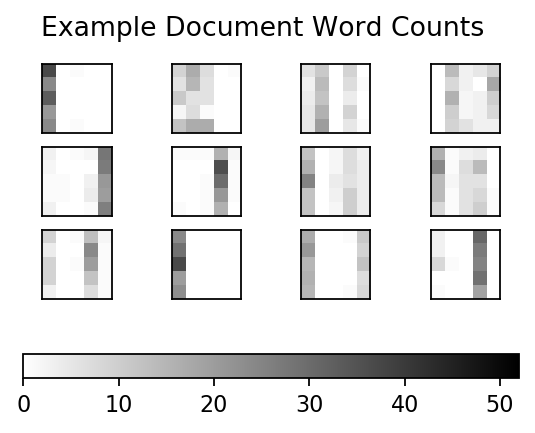

In [7]:
%matplotlib inline

fig = plot_lda(documents_training, nrows=3, ncols=4, cmap='gray_r', with_colorbar=True)
fig.suptitle('Example Document Word Counts')
fig.set_dpi(160)

## Store Data on S3

A SageMaker training job needs access to training data stored in an S3 bucket. Although training can accept data of various formats we convert the documents MXNet RecordIO Protobuf format before uploading to the S3 bucket defined at the beginning of this notebook. We do so by making use of the SageMaker Python SDK utility `numpy_to_record_serializer`.

In [ ]:
# convert documents_training to Protobuf RecordIO format
recordio_protobuf_serializer = numpy_to_record_serializer()
fbuffer = recordio_protobuf_serializer(documents_training)

# upload to S3 in bucket/prefix/train
fname = 'lda.data'
s3_object = os.path.join(prefix, 'train', fname)
boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(fbuffer)

s3_train_data = 's3://{}/{}'.format(bucket, s3_object)
print('Uploaded data to S3: {}'.format(s3_train_data))

# Training

***
First, we specify a Docker container containing the SageMaker LDA algorithm. For your convenience, a region-specific container is automatically chosen for you to minimize cross-region data communication. Information about the locations of each SageMaker algorithm is available in the documentation.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
# select the algorithm container based on this notebook's current location

region_name = boto3.Session().region_name
container = get_image_uri(region_name, 'lda')

print('Using SageMaker LDA container: {} ({})'.format(container, region_name))

Particular to a SageMaker LDA training job are the following hyperparameters:

* **`num_topics`** - The number of topics or categories in the LDA model.
  * Usually, this is not known a priori.
  * In this example, howevever, we know that the data is generated by five topics.

* **`feature_dim`** - The size of the *"vocabulary"*, in LDA parlance.
  * In this example, this is equal 25.

* **`mini_batch_size`** - The number of input training documents.

* **`alpha0`** - *(optional)* a measurement of how "mixed" are the topic-mixtures.
  * When `alpha0` is small the data tends to be represented by one or few topics.
  * When `alpha0` is large the data tends to be an even combination of several or many topics.
  * The default value is `alpha0 = 1.0`.

In addition to these LDA model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.c4`
* Current limitations:
  * SageMaker LDA *training* can only run on a single instance.
  * SageMaker LDA does not take advantage of GPU hardware.
  * (The Amazon AI Algorithms team is working hard to provide these capabilities in a future release!)

In [ ]:
session = sagemaker.Session()

# specify general training job information
lda = sagemaker.estimator.Estimator(
    container,
    role,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    sagemaker_session=session,
)

# set algorithm-specific hyperparameters
lda.set_hyperparameters(
    num_topics=num_topics,
    feature_dim=vocabulary_size,
    mini_batch_size=num_documents_training,
    alpha0=1.0,
)

# run the training job on input data stored in S3
lda.fit({'train': s3_train_data})

In [ ]:
print('Training job name: {}'.format(lda.latest_training_job.job_name))

# Inference

***

A trained model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

In [ ]:
lda_inference = lda.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',  # LDA inference may work better at scale on ml.c4 instances
)

In [ ]:
print('Endpoint name: {}'.format(lda_inference.endpoint))

In [ ]:
lda_inference.content_type = 'text/csv'
lda_inference.serializer = csv_serializer
lda_inference.deserializer = json_deserializer

In [ ]:
results = lda_inference.predict(documents_test[:12])

print(results)

It may be hard to see but the output format of SageMaker LDA inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    ...
  ]
}
```

We extract the topic mixtures, themselves, corresponding to each of the input documents.

In [ ]:
computed_topic_mixtures = np.array([prediction['topic_mixture'] for prediction in results['predictions']])

print(computed_topic_mixtures)

If you decide to compare these results to the known topic mixtures generated in the [Obtain Example Data](#ObtainExampleData) Section keep in mind that SageMaker LDA discovers topics in no particular order. That is, the approximate topic mixtures computed above may be permutations of the known topic mixtures corresponding to the same documents.

In [ ]:
print(topic_mixtures_test[0])      # known test topic mixture
print(computed_topic_mixtures[0])  # computed topic mixture (topics permuted)

In [ ]:
sagemaker.Session().delete_endpoint(lda_inference.endpoint)